<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* SVM, Decision trees y Redes neuronales
* Tipos de fronteras de clasificación y regresión.
* Métodos de *kernel*.
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de discusión y entrega: 30 de Noviembre y 3 de Diciembre (13:00 hrs) respectivamente.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF393-II-2018]

<hr style="height:2px;border:none"/>

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Tipos de fronteras en clasificación  
[2.](#segundo) Un problema* Multi-label*  
[3.](#tercero) *Taxi Trip Duration*: Predicción de duración de viaje  
[4.](#cuarto) Entendimiento de imágenes de personas

<a id="primero"></a>
## 1. Tipos de fronteras en clasificación

Como se ha discutido en clases, los problemas de clasificación pueden ser representados de distintas maneras, en donde estas representaciones definen un espacio de entrada del dominio de los datos ($\mathbb{R}_{\mathbb{X}}$). Los ejemplos dentro del espacio de entrada (*manifold*) pueden tener distintas formas, donde estas indicarán si es que estos ejemplos tendrán fronteras lineales o no. Con el propósito de analizar los distintos tipos de fronteras que definen los algoritmos de clasificación, se trabajará con un dataset sintético lo cual es ideal para analizar los diferentes tipos, así hacer un recorrido rápido por las grandes ideas en la búsqueda dela no-linealidad.

In [1]:
#%mysticplot

Este dataset de jugete está en un espacio de 2 dimensiones y es conformado por dos conjuntos de datos, pudiendo ver que la frontera entre ellos claramente no es lineal. El dataset representa al problema XOR, pero para trabajarlo de una manera distinta se generán gausianas para agregar un poco de ruido en el conjunto de entrenamiento y que no sea un problema trivial. El código que los genera es el siguiente:

In [2]:
import numpy as np
def do_gaussianXOR(n1=250,n2=250):
    rng = np.random.RandomState(0)
    u = 0.5
    std = 0.3 #el ruido se agrega aca
    primer_c = rng.normal(loc=[u,u],scale=std,size=(n1,2))
    segundo_c = rng.normal(loc=[-u,u],scale=std,size=(n2,2))
    tercer_c = rng.normal(loc=[-u,-u],scale=std,size=(n1,2))
    cuarto_c = rng.normal(loc=[u,-u],scale=std,size=(n2,2))
    X_train = np.vstack((primer_c,segundo_c,tercer_c,cuarto_c))
    Y_train = np.hstack((np.zeros(n1),np.ones(n2),np.zeros(n1),np.ones(n2)))   
    X_test = rng.uniform(low=-1.0,high=1.0,size=( (n1+n2),2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    return X_train,Y_train,X_test,Y_test

> a) Construya el conjunto de datos (*dataset*) y describa el proceso de creación de éstos. Determine cuántos registros contiene cada conjunto y visualı́celos.

El proceso de creación sucede directamente por la función do_gaussianXOR que es una función que le agrega ruido a la información para tener una mejor apresiación del error que hay en los modelos que se estudiarán más adelante.

In [3]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR()
print("Cantidad de datos de X_train",len(X_train))
print("Cantidad de datos de Y_train",len(Y_train))
print("Cantidad de datos de X_test",len(X_test))
print("Cantidad de datos de Y_test",len(Y_test))

Cantidad de datos de X_train 1000
Cantidad de datos de Y_train 1000
Cantidad de datos de X_test 500
Cantidad de datos de Y_test 500


Luego de mostrar la cantidad de información generada se procedió a visualizar los datos en cuestión del conjunto de entrenamiento y de prueba respectivamente.

In [4]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:,0], X_train[:,1], s=50, c=Y_train, cmap=plt.cm.winter)

plt.scatter(X_test[:,0], X_test[:,1], s=50, c=Y_test, cmap=plt.cm.winter)

Para visualizar las fronteras de los distintos algoritmos utilice el siguiente código:

> b) Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Comente cualitativamente lo que observa.

In [5]:
import matplotlib.pyplot as plt
def visualize_border(model,x,y,title=""):
    fig, axis = plt.subplots(1, 1,figsize=(12, 6))

    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #or predict_proba
    Z = Z.reshape(xx.shape)
    Zplot = Z > 0.5
    
    axis.scatter(x[:,0],x[:,1],s=50,c=y,zorder=10,cmap=plt.cm.winter)
    axis.contour(xx, yy, Z,levels=[-1, 0, 1])
    axis.pcolormesh(xx, yy, Zplot ,cmap=plt.cm.YlGn)
    plt.title(title)
    plt.show()

C:\Users\kzep\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


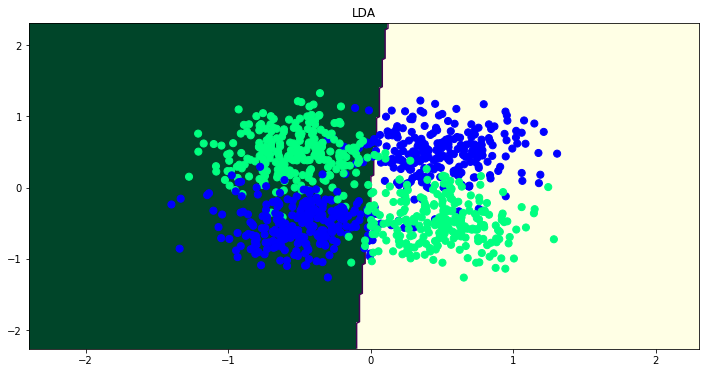

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()
model.fit(X_train,Y_train)
visualize_border(model,X_train,Y_train,"LDA")

Se observa que el problema no es linealmente separable, pero se podrían considerar dos rectas tales que nos corten los conjuntos en forma de cruz. esto considera el supuesto de que no son 2 subconjuntos, sino 4 (2 y 2) como se hará a continuación.

> c) Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué  distribución de probabilidad asumen cada uno?

C:\Users\kzep\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


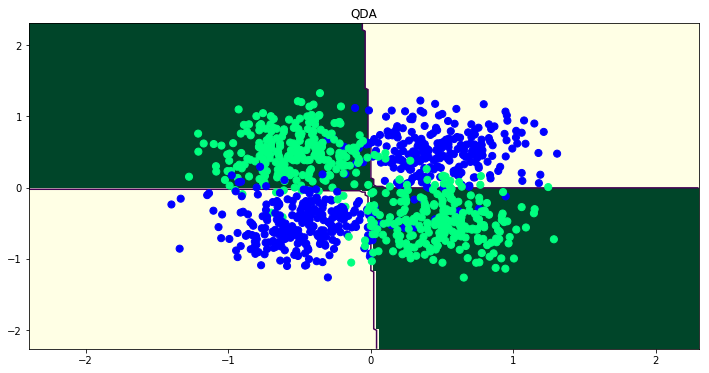

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA()
model.fit(X_train,Y_train)
visualize_border(model,X_train,Y_train,"QDA")

Es importante destacar que el modelo QDA disminuye el error tomando las consideraciones antes mencionadas.

Para lo que sigue de la actividad se trabajará con una widget interactiva [[2]](#refs) para sintonizar los parámetros de regularización o estructurales de los distintos algoritmos. Por ello cada vez que se modifique el parámetro en la ventana se entrenará el modelo y se visualizará la frontera en la misma imagen.

In [8]:
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X_train,Y_train)#here choose train/test or both!

> d) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) Lineal no puede resolver el problema, para esto construyala a través de *sklearn*. Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$. Analice cualitativamente lo observado, para validar su análisis cualitativo calcule el *accuracy* sobre el conjunto de pruebas.

In [9]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='linear')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 0 #define your range
p_max = 15 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=7, description='param', max=15), Output()), _dom_classes=('widget-intera…

Además de ser lento, SVM considera una especia de frontera acotada para arreglar las soluciones, pero no se extiende a un conjunto multiple de fronteras, ya que surgirían problemas en el modelo en la intersección de estas (lo que otorga 50% de chances de acertar, que es lo mismo que azar. Es por esto que SVM no puede resolver el probelma


> e) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) no Lineal puede resolver el problema, para ésto construya una SVM no Lineal a través de un **kernel** [[3]](#refs). Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$ y con diferentes kernels. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [ ]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    #model.set_params(C=C,kernel='rbf') #try poly
    model.set_params(C=C,kernel='poly') #try poly
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 1 #define your range
p_max = 15 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))



interactive(children=(IntSlider(value=8, description='param', max=15, min=1), Output()), _dom_classes=('widget…

Utilizando la consideración se observa que existe una separación no lineal, por lo que se evita el problema ya antes mencionado y el errror se ha disminuido con respecto a los modelos vistos anteriormente. Este es el mejor, por ahora.

> f) Demuestre experimentalmente que un Árbol de Decisión de múltiples niveles puede resolver el problema ¿Qué pasa con un nivel? Para ésto contruya el Árbol de Decisión a través de *sklearn*, puede utilizar el criterio y la función de partición que prefiera. Mediante la *widget* interactiva explore diferentes valores del parámetro de máxima profundidad del árbol. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [ ]:
from sklearn.tree import DecisionTreeClassifier as Tree
def train_model(param):
    model = Tree() #edit the train_model function
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model


p_min = 1 #define your range
p_max = 40 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

Las fronteras generadas a través del modelo de Árbol de desición no son tan sutiles o claras como las obtenidas con el modelo anterior, pero esto implica que en cierto modo las categorías "están mal" en el sentido de que existe una función f tal que cambia la muestra a una linealmente separable y la prueba de ello es tomar una parametrización del espacio por pedazos y luego transformar estos pedazos como dos conexos de cada categoría.

> g) Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema. Para esto construya un perceptrón multi-capa, con una capa escondida, variando el número de neuronas $N_h$ a través de la *widget* interactiva. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    return model
p_min = 0 #define your range
p_max = 30 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

> h) Construya un algoritmo $k$-NN para la clasificación del problema. Mediante la *widget* interactiva explore diferentes valores del parámetro $k$. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def train_model(param):
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test, Y_test))
    return model
p_min = 1 #define your range
p_max = 50#define your range
interactive(visualize_border_interactive,param=(p_min,p_max))


Este modelo ha sido el más certero y amigable al momento de definir las fronteras entre los conjuntos al variar el parametro.


> i) Vuelva a generar datos, pero ahora de manera desbalanceada por clase, con más ejemplos en una clase que en otra, pero manteniendo el conjunto de pruebas para verificación. Visualicelo apropiadamente.

In [ ]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR(n1=250,n2=5)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:,0], X_train[:,1], s=50, c=Y_train, cmap=plt.cm.winter)

plt.scatter(X_test[:,0], X_test[:,1], s=50, c=Y_test, cmap=plt.cm.winter)

j) Escoga las Máquinas de Soporte Vectorial con kernel RBF ($C=1$) o un Árbol de Decisión ($depth=5$) para entrenar sobre estos datos desbalanceados, mida el *Accuracy* sobre el conjunto de pruebas.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 

model =DecisionTreeClassifier()#SVM, Decision Trees or Neural Network
model.set_params(max_depth=5,criterion='gini',splitter='best')
model.fit(X_train,Y_train)
#accuracy_score(model.predict(X_test),Y_test, normalize=True)#es un testeo
print("test accuracy:", model.score(X_test,Y_test))#este comando con el anterior son equivalentes



> k) Ahora verifique que se puede mejorar la métrica a través de poner un peso en la función objetivo para las distintas clases, *seteelo* a mano o utilize la función *balanced* para que reduzca el impacto de lo datos de la clase mayoritaria en la función objetivo o que aumente el impacto de los datos de la clase minoritaria.

In [ ]:
classes_weights = {0: 0.1, 1: 10} #or choose..
#model.set_params(C=1,kernel='rbf',class_weight=classes_weights or 'balanced') #for svm

model.set_params(max_depth=5,criterion='gini',splitter='best',class_weight=classes_weight) #for decision tree
model.fit(X_train,Y_train)
model.score(X_test,Y_test)